# How To: Land-Use-Land-Cover Prediction for Slovenia

This notebook shows the steps towards constructing a machine learning pipeline for predicting the land use and land cover for the region of Republic of Slovenia. We will use satellite images obtained by ESA's Sentinel-2 to train a model and use it for prediction. The example will lead you through the whole process of creating the pipeline, with details provided at each step.

## Before you start

### Requirements

In order to run the example you'll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://www.sentinel-hub.com/trial). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, please configure the `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your `oauth` client id and secret. 

### Overview

#### Part 1:

1. Define the Area-of-Interest (AOI):
   * Obtain the outline of Slovenia (provided)
   * Split into manageable smaller tiles
   * Select a small 5x5 area for classification
2. Use the integrated [sentinelhub-py](https://github.com/sentinel-hub/sentinelhub-py) package in order to fill the EOPatches with some content (band data, cloud masks, ...)
   * Define the time interval (this example uses the whole year of 2019)
3. Add additional information from band combinations (norm. vegetation index - NDVI, norm. water index - NDWI)
4. Add a reference map (provided)
   * Convert provided vector data to raster and add it to EOPatches
   
#### Part 2:

5. Prepare the training data
   * Remove too cloudy scenes
   * Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Apply erosion 
   * Random spatial sampling of the EOPatches
   * Split patches for training/validation
6. Construct and train the ML model
   * Make the prediction for each patch 
7. Validate the model
8. Visualise the results

Let's start!

In [14]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import datetime
import itertools

# Built-in modules
import os

# Basics of Python data handling and visualization
import numpy as np
from aenum import MultiValueEnum

np.random.seed(42)
import geopandas as gpd
import joblib

# Machine learning
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from shapely.geometry import Polygon
from sklearn import metrics, preprocessing
from tqdm.auto import tqdm

from sentinelhub import DataCollection, UtmZoneSplitter

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask,
    linearly_connect_tasks,
)
from eolearn.features import NormalizedDifferenceIndexTask, SimpleFilterTask
from eolearn.features.extra.interpolation import LinearInterpolationTask
from eolearn.geometry import ErosionTask, VectorToRasterTask
from eolearn.io import ExportToTiffTask, SentinelHubInputTask, VectorImportTask
from eolearn.ml_tools import FractionSamplingTask

In [15]:
from sentinelhub import SHConfig

config = SHConfig("ken-profile")
#config.instance_id='c58f77b7-a111-4860-996c-f7cce4430a9f'
#config.sh_client_id='0ffd5411-58f2-46b5-b61e-89fea2d633c5'
#config.sh_client_secret='SHWG8zpwDMTIR9AXAliFUBupHt2QPAsH'
#config.save("ken-profile")
config


SHConfig(
  instance_id='********************************0a9f',
  sh_client_id='********************************33c5',
  sh_client_secret='****************************PAsH',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
  max_retries=None,
)

# Part 1

## 1. Define the Area-of-Interest (AOI):

* A geographical shape of Slovenia was taken from [Natural Earth database](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/) and a buffer of 500 m was applied. The shape is available in repository: `example_data/svn_border.geojson`
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)
* Split it into smaller, manageable, non-overlapping rectangular tiles
* Run classification on a selected 5x5 area

Be sure that your choice of CRS is the same as the CRS of your reference data.

In the case that you are having problems with empty data being downloaded, try changing the CRS to something that suits the location of the AOI better.

### Get country boundary

Dimension of the area is 243184 x 161584 m2


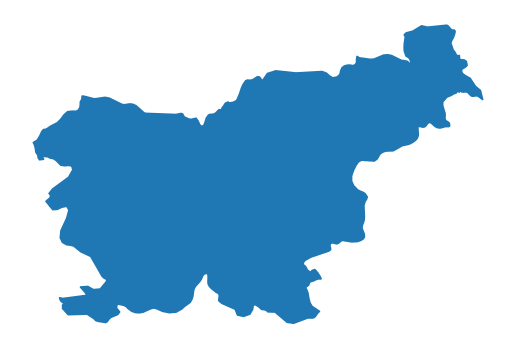

In [16]:
# Folder where data for running the notebook is stored
DATA_FOLDER = "example_data"
# Locations for collected data and intermediate results
EOPATCH_FOLDER = os.path.join(".", "eopatches")
EOPATCH_SAMPLES_FOLDER = os.path.join(".", "eopatches_sampled")
RESULTS_FOLDER = os.path.join(".", "results")
for folder in (EOPATCH_FOLDER, EOPATCH_SAMPLES_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Load geojson file
country = gpd.read_file(os.path.join(DATA_FOLDER, "svn_border.geojson"))
# Add 500m buffer to secure sufficient data near border
country = country.buffer(500)

# Get the country's shape in polygon format
country_shape = country.geometry.values[0]

# Plot country
country.plot()
plt.axis("off")

# Print size
country_width = country_shape.bounds[2] - country_shape.bounds[0]
country_height = country_shape.bounds[3] - country_shape.bounds[1]
print(f"Dimension of the area is {country_width:.0f} x {country_height:.0f} m2")

### Split to smaller tiles and choose a 5x5 area

The splitting choice depends on the available resources of your computer. An EOPatch with a size of has around 500 x 500 pixels at 10 meter resolution has a size ob about ~1 GB.

In [17]:
# Create a splitter to obtain a list of bboxes with 5km sides
bbox_splitter = UtmZoneSplitter([country_shape], country.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info["index"] for info in info_list]
idxs_x = [info["index_x"] for info in info_list]
idxs_y = [info["index_y"] for info in info_list]

bbox_gdf = gpd.GeoDataFrame({"index": idxs, "index_x": idxs_x, "index_y": idxs_y}, crs=country.crs, geometry=geometry)

# select a 5x5 area (id of center patch)
ID = 616

# Obtain surrounding 5x5 patches
patch_ids = []
for idx, info in enumerate(info_list):
    if abs(info["index_x"] - info_list[ID]["index_x"]) <= 2 and abs(info["index_y"] - info_list[ID]["index_y"]) <= 2:
        patch_ids.append(idx)

# Check if final size is 5x5
if len(patch_ids) != 5 * 5:
    print("Warning! Use a different central patch ID, this one is on the border.")

# Change the order of the patches (useful for plotting)
patch_ids = np.transpose(np.fliplr(np.array(patch_ids).reshape(5, 5))).ravel()

# Save to shapefile
shapefile_name = "grid_slovenia_500x500.gpkg"
bbox_gdf.to_file(os.path.join(RESULTS_FOLDER, shapefile_name), driver="GPKG")

### Visualize the selection

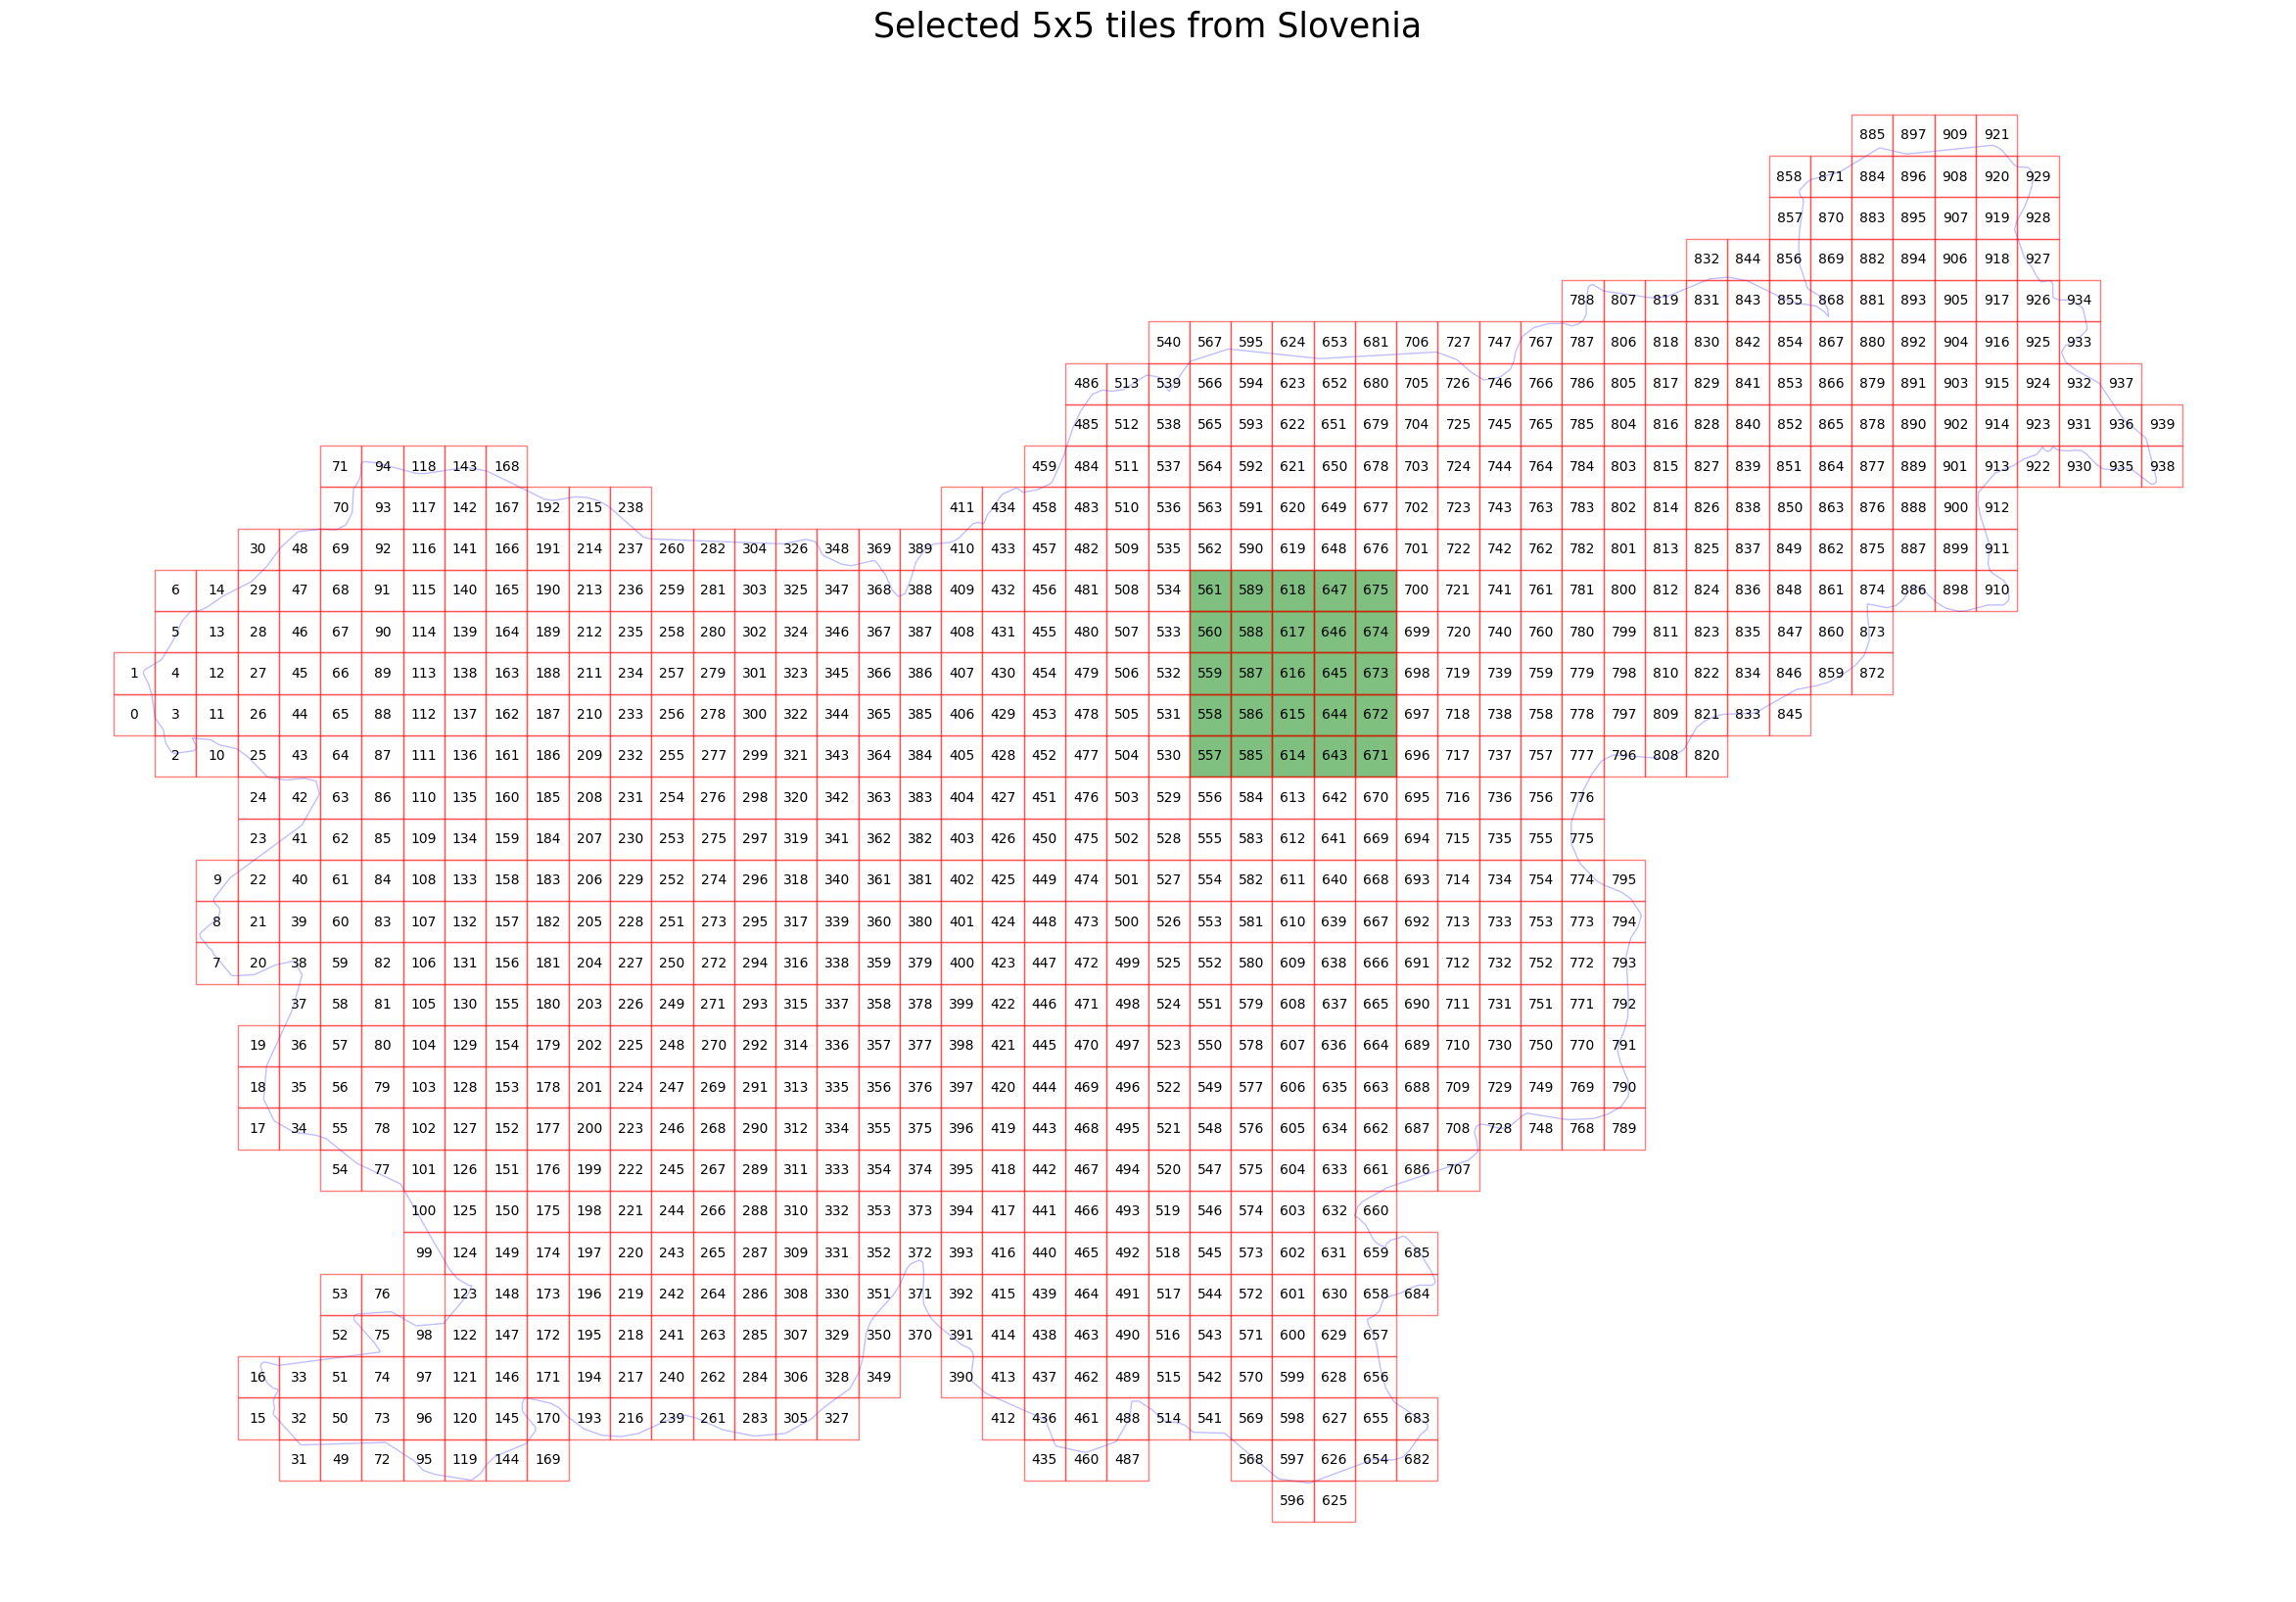

In [18]:
# Display bboxes over country
fig, ax = plt.subplots(figsize=(30, 30))
ax.set_title("Selected 5x5 tiles from Slovenia", fontsize=25)
country.plot(ax=ax, facecolor="w", edgecolor="b", alpha=0.5)
bbox_gdf.plot(ax=ax, facecolor="w", edgecolor="r", alpha=0.5)

for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info["index"], ha="center", va="center")

# Mark bboxes of selected area
bbox_gdf[bbox_gdf.index.isin(patch_ids)].plot(ax=ax, facecolor="g", edgecolor="r", alpha=0.5)

plt.axis("off");

## 2. - 4. Fill EOPatches with data:

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch:

* L1C custom list of bands [B02, B03, B04, B08, B11, B12], which corresponds to [B, G, R, NIR, SWIR1, SWIR2] wavelengths.

* SentinelHub's cloud mask

Additionally, we will add:

* Calculated NDVI, NDWI, and NDBI information

* A mask of validity, based on acquired data from Sentinel and cloud coverage. Valid pixel is if:
   
    1. IS_DATA == True
    2. CLOUD_MASK == 0 (1 indicates cloudy pixels and 255 indicates `NO_DATA`)

An EOPatch is created and manipulated using EOTasks, which are chained in an EOWorkflow. In this example the final workflow is executed on all patches, which are saved to the specified directory.

### Define some needed custom EOTasks

In [19]:
class SentinelHubValidDataTask(EOTask):
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """

    def __init__(self, output_feature):
        self.output_feature = output_feature

    def execute(self, eopatch):
        eopatch[self.output_feature] = eopatch.mask["IS_DATA"].astype(bool) & (~eopatch.mask["CLM"].astype(bool))
        return eopatch


class AddValidCountTask(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """

    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch[FeatureType.MASK_TIMELESS, self.name] = np.count_nonzero(eopatch.mask[self.what], axis=0)
        return eopatch

### Define the workflow tasks

In [20]:
# BAND DATA
# Add a request for S2 bands.
# Here we also do a simple filter of cloudy scenes (on tile level).
# The s2cloudless masks and probabilities are requested via additional data.
band_names = ["B02", "B03", "B04", "B08", "B11", "B12"]
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, "dataMask", "IS_DATA"), (FeatureType.MASK, "CLM"), (FeatureType.DATA, "CLP")],
    max_threads=5,
)


# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDVI"), [band_names.index("B08"), band_names.index("B04")]
)
ndwi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDWI"), [band_names.index("B03"), band_names.index("B08")]
)
ndbi = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), (FeatureType.DATA, "NDBI"), [band_names.index("B11"), band_names.index("B08")]
)


# VALIDITY MASK
# Validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_validmask = SentinelHubValidDataTask((FeatureType.MASK, "IS_VALID"))

# COUNTING VALID PIXELS
# Count the number of valid observations per pixel using valid data mask
add_valid_count = AddValidCountTask("IS_VALID", "VALID_COUNT")

# SAVING TO OUTPUT (if needed)
save = SaveTask(EOPATCH_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

#### Help! I prefer to calculate cloud masks of my own!

If you wish to calculate `s2cloudless` masks and probabilities (almost) from scratch, you can do this by using the following two EOTasks instead of the first one above

```python
band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B10', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA')],
)

add_clm = CloudMaskTask(data_feature='BANDS',
                        all_bands=True,
                        processing_resolution=160,
                        mono_features=('CLP', 'CLM'),
                        mask_feature=None,
                        average_over=16,
                        dilation_size=8)

```

#### Reference map task

For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a geopackage, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

* lulcid = 0, name = no data
* lulcid = 1, name = cultivated land
* lulcid = 2, name = forest
* lulcid = 3, name = grassland
* lulcid = 4, name = shrubland
* lulcid = 5, name = water
* lulcid = 6, name = wetlands
* lulcid = 7, name = tundra
* lulcid = 8, name = artificial surface
* lulcid = 9, name = bareland
* lulcid = 10, name = snow and ice

We have defined a land cover enum class for ease of use below.

In [21]:
class LULC(MultiValueEnum):
    """Enum class containing basic LULC types"""

    NO_DATA = "No Data", 0, "#ffffff"
    CULTIVATED_LAND = "Cultivated Land", 1, "#ffff00"
    FOREST = "Forest", 2, "#054907"
    GRASSLAND = "Grassland", 3, "#ffa500"
    SHRUBLAND = "Shrubland", 4, "#806000"
    WATER = "Water", 5, "#069af3"
    WETLAND = "Wetlands", 6, "#95d0fc"
    TUNDRA = "Tundra", 7, "#967bb6"
    ARTIFICIAL_SURFACE = "Artificial Surface", 8, "#dc143c"
    BARELAND = "Bareland", 9, "#a6a6a6"
    SNOW_AND_ICE = "Snow and Ice", 10, "#000000"

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(len(LULC) + 1)], lulc_cmap.N)

In [32]:
lulc_cmap(0)

(1.0, 1.0, 1.0, 1.0)

The main point of this task is to create a raster mask from the vector polygons and add it to the eopatch. With this procedure, any kind of a labeled shapefile can be transformed into a raster reference map. This result is achieved with the existing task `VectorToRaster` from the `eolearn.geometry` package. All polygons belonging to the each of the classes are separately burned to the raster mask.

Land use data are public in Slovenia, you can use the provided partial dataset for this example, or download the full dataset (if you want to upscale the project) [from our bucket](http://eo-learn.sentinel-hub.com/). The datasets have already been pre-processed for the purposes of the example.

In [22]:
land_use_ref_path = os.path.join(DATA_FOLDER, "land_use_10class_reference_slovenia_partial.gpkg")

import requests

url = "http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/land_use_10class_reference_slovenia_partial.gpkg"
r = requests.get(url, allow_redirects=True)
with open(land_use_ref_path, "wb") as gpkg:
    gpkg.write(r.content)

In [34]:
lulc_geojson = gpd.read_file(land_use_ref_path,rows=10).to_crs('4326')
lulc_geojson.head()

,RABA_PID,RABA_ID,VIR,AREA,STATUS,D_OD,lulcid,lulcname,geometry
0,3110752.0,1211,Dof5,347.1811,P,2017-01-18,1,cultivated land,"MULTIPOLYGON (((15.10050 46.35473, 15.10041 46..."
1,1999627.0,1300,Dof5,1598.0406,P,2016-12-13,3,grassland,"MULTIPOLYGON (((15.04093 46.25787, 15.04100 46..."
2,5163032.0,3000,Dof5,178.3287,P,2017-12-12,8,artificial surface,"MULTIPOLYGON (((15.20625 46.31035, 15.20645 46..."
3,5032941.0,1222,Dof5,1604.5896,P,2017-03-01,1,cultivated land,"MULTIPOLYGON (((15.10987 46.22301, 15.10997 46..."
4,5479898.0,1500,Dof5,326.2020,P,2016-12-13,4,schrubland,"MULTIPOLYGON (((15.26178 46.27985, 15.26174 46..."


In [35]:
lulc_geojson.

['AREA',
 'D_OD',
 'RABA_ID',
 'RABA_PID',
 'STATUS',
 'T',
 'VIR',
 '_AXIS_LEN',
 '_AXIS_ORDERS',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__arrow_c_stream__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__dataframe__',
 '__dataframe_consortium_standard__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new_

In [23]:
vector_feature = FeatureType.VECTOR_TIMELESS, "LULC_REFERENCE"

vector_import_task = VectorImportTask(vector_feature, land_use_ref_path)

rasterization_task = VectorToRasterTask(
    vector_feature,
    (FeatureType.MASK_TIMELESS, "LULC"),
    values_column="lulcid",
    raster_shape=(FeatureType.MASK, "IS_DATA"),
    raster_dtype=np.uint8,
)

### Define the workflow

All the tasks that were defined so far create and fill the EOPatches. The tasks need to be put in some order and executed one by one. This can be achieved by manually executing the tasks, or more conveniently, defining an `EOWorkflow` which does this for you.

The following workflow is created and executed:

1. Create EOPatches with band and cloud data
3. Calculate and add NDVI, NDWI, NORM
4. Add mask of valid pixels
5. Add scalar feature representing the count of valid pixels
7. Save eopatches

An EOWorkflow can be linear or more complex, but it should be acyclic. Here we will use the linear case of the EOWorkflow, available as `LinearWorkflow`

Define the workflow

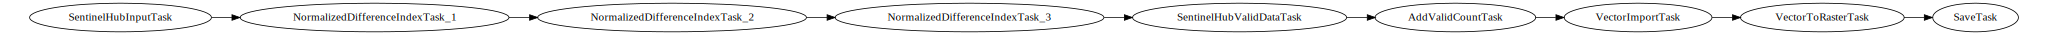

In [24]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    add_data, ndvi, ndwi, ndbi, add_sh_validmask, add_valid_count, vector_import_task, rasterization_task, save
)
workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

_This may take some time, so go grab a cup of coffee ..._

In [36]:
%%time

# Time interval for the SH request
time_interval = ["2019-01-01", "2019-12-31"]

# Define additional parameters of the workflow
input_node = workflow_nodes[0]
save_node = workflow_nodes[-1]
execution_args = []
for idx, bbox in enumerate(bbox_list[patch_ids]):
    execution_args.append(
        {
            input_node: {"bbox": bbox, "time_interval": time_interval},
            save_node: {"eopatch_folder": f"eopatch_{idx}"},
        }
    )

# Execute the workflow
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=4)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/25 [00:00<?, ?it/s]

/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv/versions/3.12.3/envs/satellite-crops/lib/python3.12/site-packages/sentinelhub/download/sentinelhub_client.py:93: SHRateLimitWarning: Download rate limit hit
  warnings.warn("Download rate limit hit", category=SHRateLimitWarning)
/home/ken/.pyenv

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

### Visualize the patches

Let's load a single EOPatch and look at the structure. By executing 
```
EOPatch.load('./eopatches/eopatch_0/')
```

We obtain the following structure:

```
EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(48, 500, 500, 6), dtype=float32)
    CLP: numpy.ndarray(shape=(48, 500, 500, 1), dtype=uint8)
    NDBI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(48, 500, 500, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(48, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(48, 500, 500, 1), dtype=uint8)
    IS_VALID: numpy.ndarray(shape=(48, 500, 500, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    LULC: numpy.ndarray(shape=(500, 500, 1), dtype=uint8)
    VALID_COUNT: numpy.ndarray(shape=(500, 500, 1), dtype=int64)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    LULC_REFERENCE: geopandas.GeoDataFrame(columns=['RABA_PID', 'RABA_ID', 'VIR', 'AREA', 'STATUS', 'D_OD', 'lulcid', 'lulcname', 'geometry'], length=1145, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.8
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-01-01T00:00:00', '2019-12-31T23:59:59')
  }
  bbox: BBox(((500000.0, 5135000.0), (505000.0, 5140000.0)), crs=CRS('32633'))
  timestamps: [datetime.datetime(2019, 1, 1, 10, 7, 42), ..., datetime.datetime(2019, 12, 7, 10, 7, 45)], length=48
)
```

It is possible to then access various EOPatch content via calls like:
```
eopatch.timestamps
eopatch.mask['LULC']
eopatch.data['NDVI'][0]
eopatch.data['BANDS'][5][..., [3, 2, 1]]

```

Due to the `maxcc` filtering, not all patches have the same amount of timestamps. 

Let's select a date and draw the closest timestamp for each eopatch.

  0%|          | 0/25 [00:00<?, ?it/s]

CreateFailed: root path '/home/ken/code/Ken4git/satellite-crops/eopatches/eopatch_4' does not exist

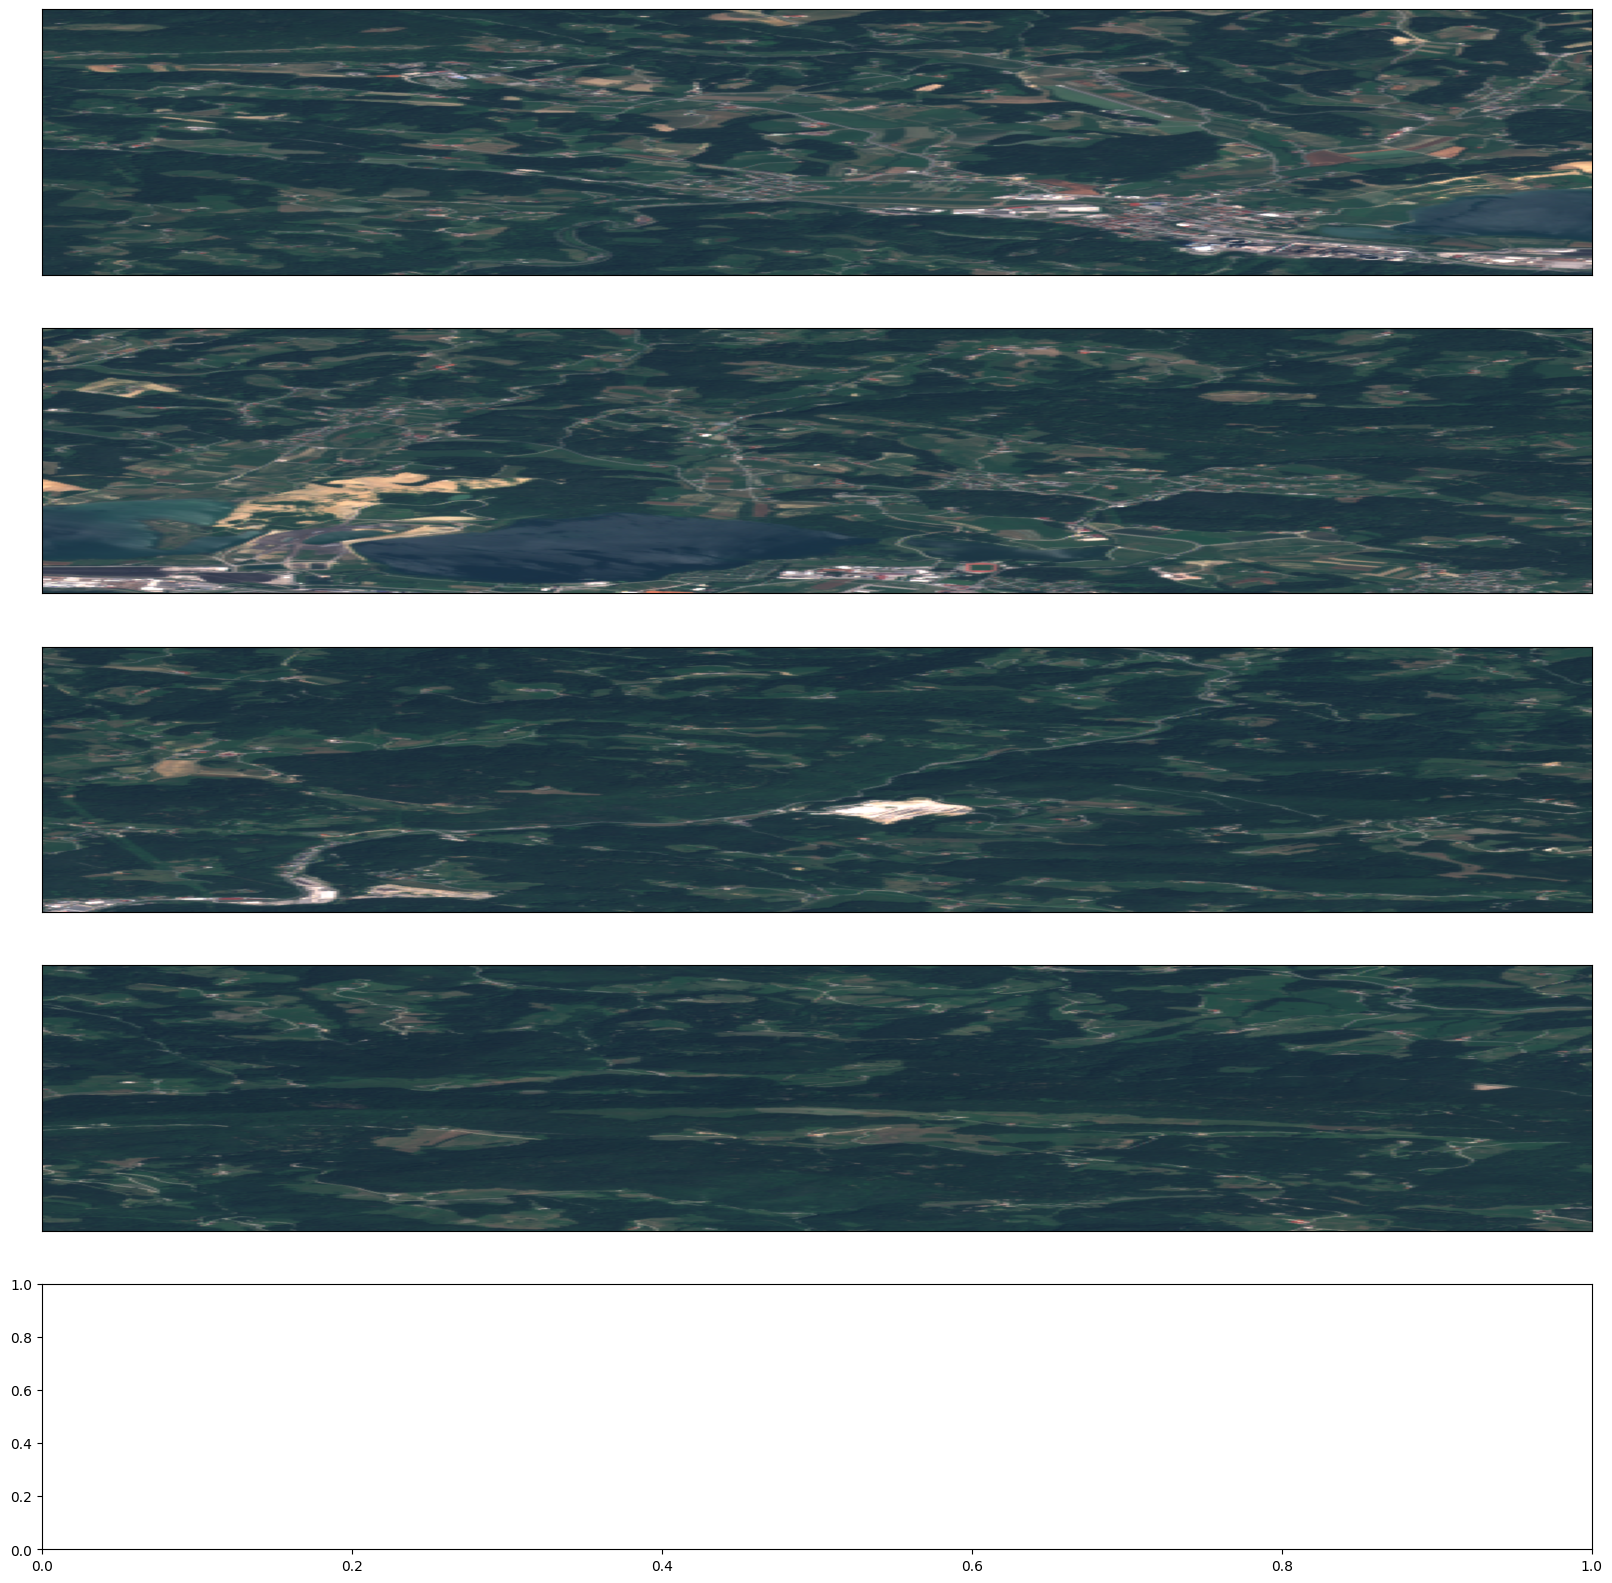

In [25]:
# Draw the RGB images
fig, axs = plt.subplots(nrows=5, figsize=(20, 20))

date = datetime.datetime(2019, 7, 1)

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    dates = np.array([timestamp.replace(tzinfo=None) for timestamp in eopatch.timestamps])
    closest_date_id = np.argsort(abs(date - dates))[0]

    ax = axs[i]# // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["BANDS"][closest_date_id][..., [2, 1, 0]] * 3.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

### Visualize the reference map

  0%|          | 0/25 [00:00<?, ?it/s]

CreateFailed: root path '/home/ken/code/Ken4git/satellite-crops/eopatches/eopatch_4' does not exist

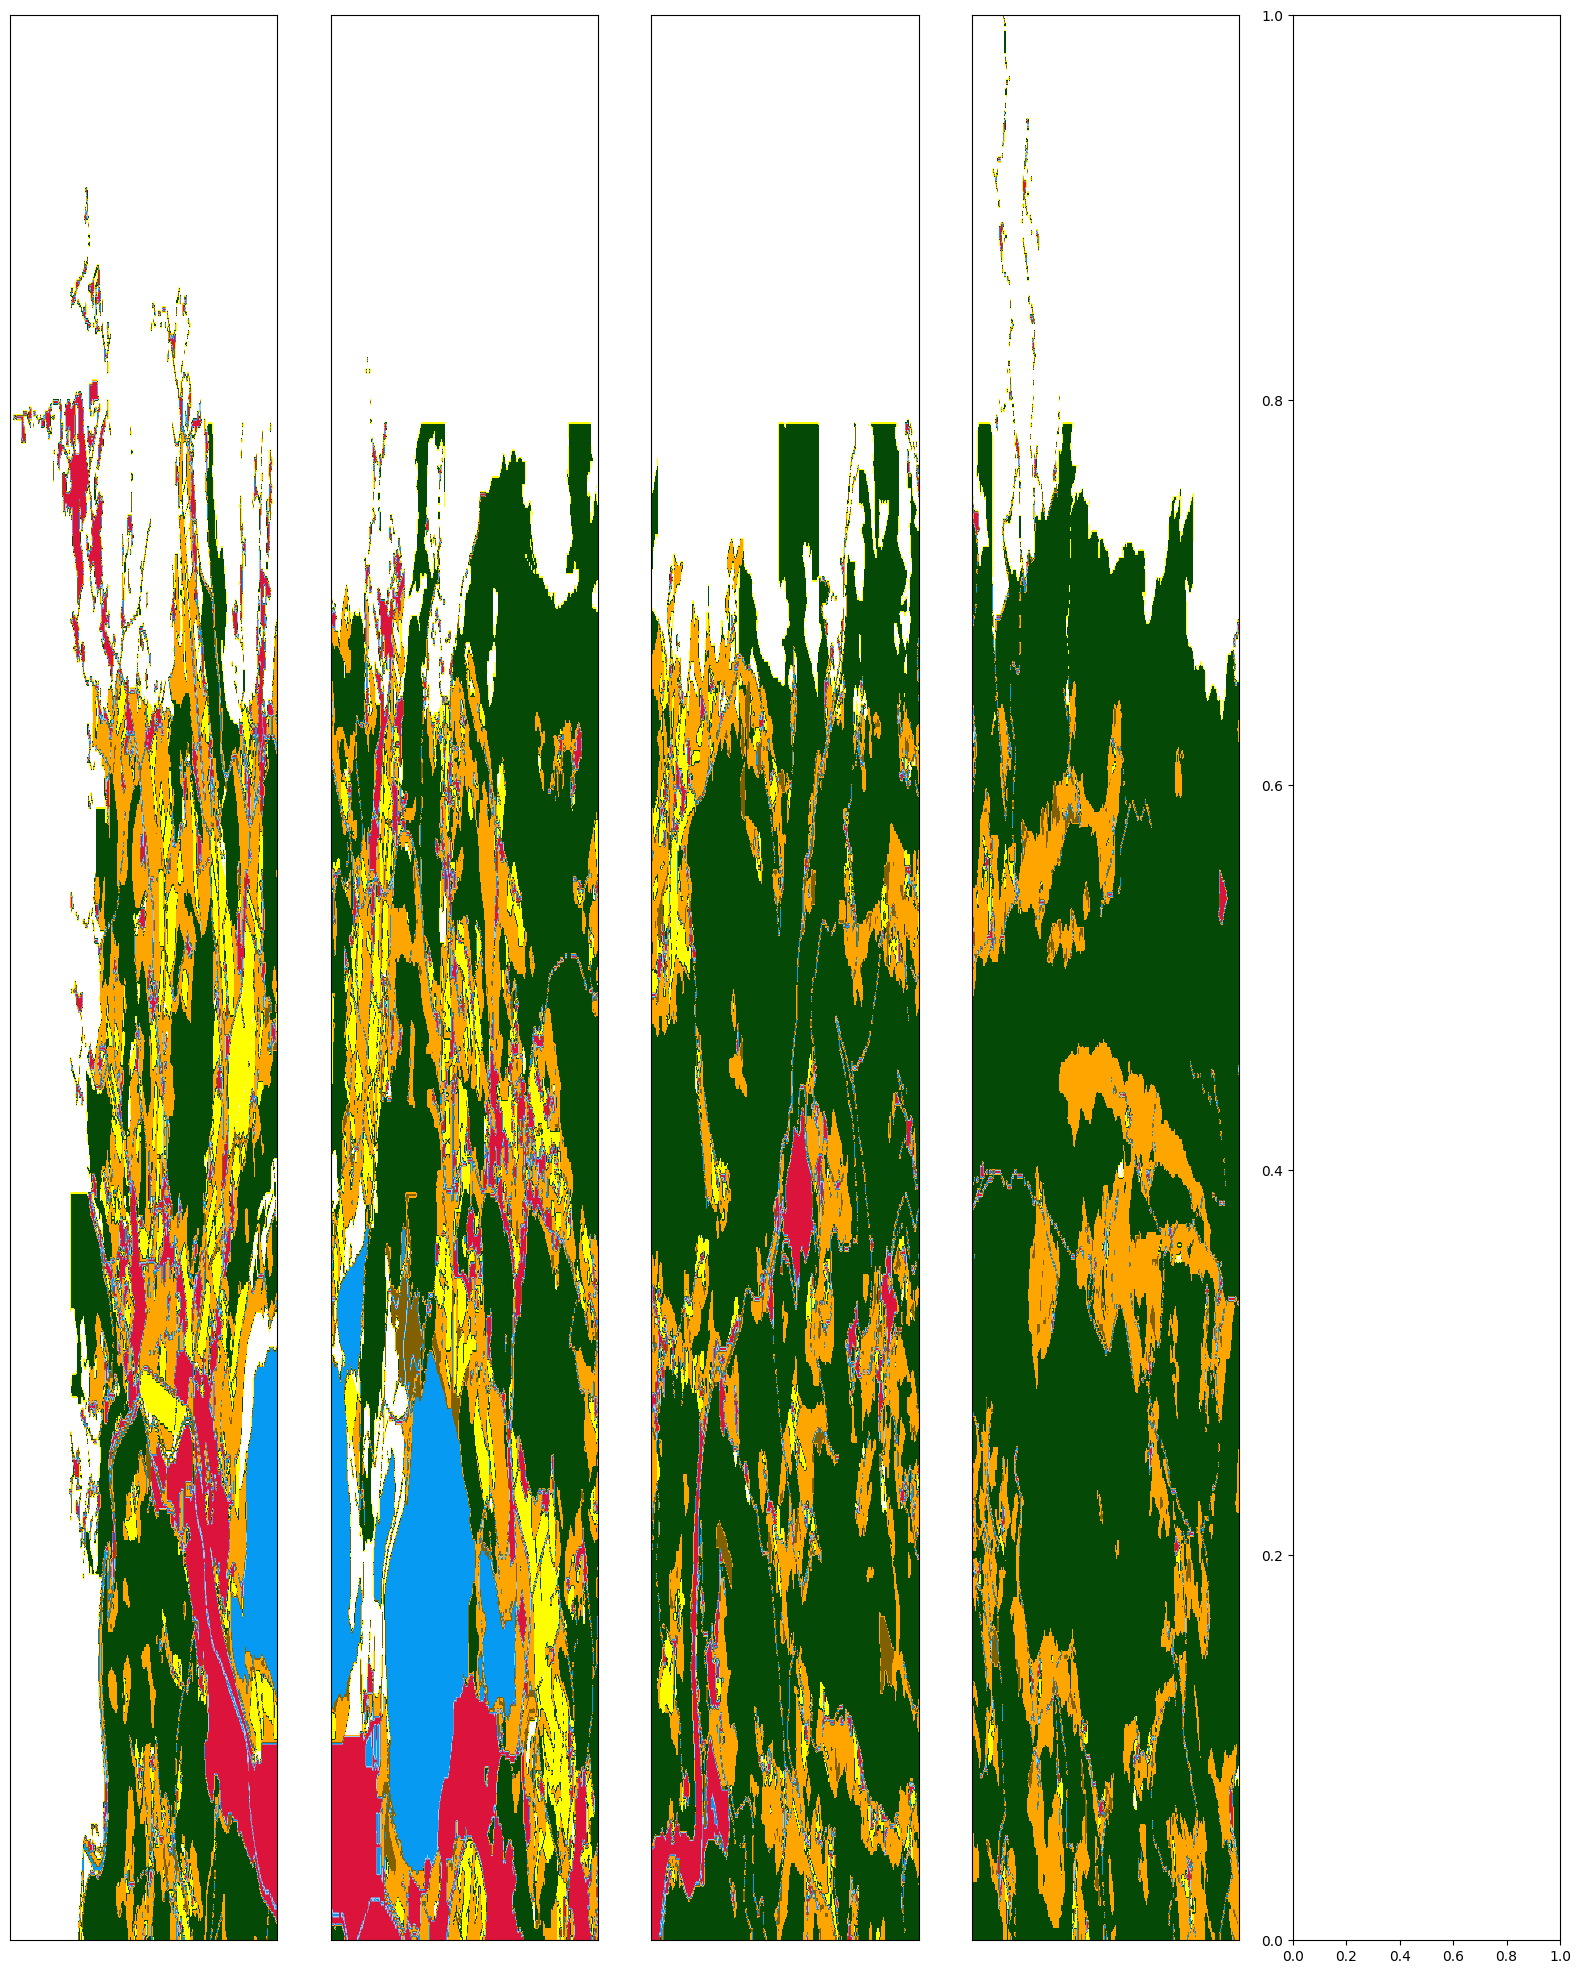

In [28]:
fig, axs = plt.subplots( ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    ax = axs[i]# // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LULC"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show();

### Plot the map of valid pixel counts

In [ ]:
# Calculate min and max counts of valid data per pixel
vmin, vmax = None, None
for i in range(len(patch_ids)):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    data = eopatch.mask_timeless["VALID_COUNT"].squeeze()
    vmin = np.min(data) if vmin is None else (np.min(data) if np.min(data) < vmin else vmin)
    vmax = np.max(data) if vmax is None else (np.max(data) if np.max(data) > vmax else vmax)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["VALID_COUNT"].squeeze(), vmin=vmin, vmax=vmax, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

### Spatial mean of NDVI

Plot the mean of NDVI over all pixels in a selected patch throughout the year. Filter out clouds in the mean calculation.

In [ ]:
eopatch = EOPatch.load(os.path.join(EOPATCH_FOLDER, f"eopatch_{i}"), lazy_loading=True)

ndvi = eopatch.data["NDVI"]
mask = eopatch.mask["IS_VALID"]
time = np.array(eopatch.timestamps)
t, w, h, _ = ndvi.shape

ndvi_clean = ndvi.copy()
ndvi_clean[~mask] = np.nan  # Set values of invalid pixels to NaN's

# Calculate means, remove NaN's from means
ndvi_mean = np.nanmean(ndvi.reshape(t, w * h), axis=1)
ndvi_mean_clean = np.nanmean(ndvi_clean.reshape(t, w * h), axis=1)
time_clean = time[~np.isnan(ndvi_mean_clean)]
ndvi_mean_clean = ndvi_mean_clean[~np.isnan(ndvi_mean_clean)]

fig = plt.figure(figsize=(20, 5))
plt.plot(time_clean, ndvi_mean_clean, "s-", label="Mean NDVI with cloud cleaning")
plt.plot(time, ndvi_mean, "o-", label="Mean NDVI without cloud cleaning")
plt.xlabel("Time", fontsize=15)
plt.ylabel("Mean NDVI over patch", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc=2, prop={"size": 15});

### Temporal mean of NDVI

Plot the time-wise mean of NDVI for the whole region. Filter out clouds in the mean calculation.

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    ndvi = eopatch.data["NDVI"]
    mask = eopatch.mask["IS_VALID"]
    ndvi[~mask] = np.nan
    ndvi_mean = np.nanmean(ndvi, axis=0).squeeze()

    ax = axs[i // 5][i % 5]
    im = ax.imshow(ndvi_mean, vmin=0, vmax=0.8, cmap=plt.get_cmap("YlGn"))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

### Plot the average cloud probability

Plot te average of the cloud probability for each pixel, take the cloud mask into account.

Some structures can be seen like road networks etc., indicating a bias of the cloud detector towards these objects.

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    clp = eopatch.data["CLP"].astype(float) / 255
    mask = eopatch.mask["IS_VALID"]
    clp[~mask] = np.nan
    clp_mean = np.nanmean(clp, axis=0).squeeze()

    ax = axs[i // 5][i % 5]
    im = ax.imshow(clp_mean, vmin=0.0, vmax=0.3, cmap=plt.cm.inferno)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
plt.show()

# Part 2

## 5. Prepare the training data

We will create a new workflow that processes the data:

1. Remove too cloudy scenes
   * Check the ratio of the valid data for each patch and for each time frame
   * Keep only time frames with > 80 % valid coverage (no clouds)
2. Concatenate BAND, NDVI, NDWI, NDBI info into a single feature called FEATURES
3. Perform temporal interpolation (filling gaps and resampling to the same dates)
   * Create a task for linear interpolation in the temporal dimension
   * Provide the cloud mask to tell the interpolating function which values to update
4. Perform erosion
   * This removes artefacts with a width of 1 px, and also removes the edges between polygons of different classes
5. Random spatial sampling of the EOPatches
   * Randomly take a subset of pixels from a patch to use in the machine learning training
6. Split patches for training/validation
   * Split the patches into a training and validation set

### Define EOTasks

In [ ]:
class ValidDataFractionPredicate:
    """Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid if the
    valid data fraction is above the specified threshold.
    """

    def __init__(self, threshold):
        self.threshold = threshold

    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [ ]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_FOLDER)

# FEATURE CONCATENATION
concatenate = MergeFeatureTask({FeatureType.DATA: ["BANDS", "NDVI", "NDWI", "NDBI"]}, (FeatureType.DATA, "FEATURES"))

# FILTER OUT CLOUDY SCENES
# Keep frames with > 80% valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, "IS_VALID"), valid_data_predicate)

# LINEAR TEMPORAL INTERPOLATION
# linear interpolation of full time-series and date resampling
resampled_range = ("2019-01-01", "2019-12-31", 15)
linear_interp = LinearInterpolationTask(
    (FeatureType.DATA, "FEATURES"),  # name of field to interpolate
    mask_feature=(FeatureType.MASK, "IS_VALID"),  # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, "LULC")],  # features to keep
    resample_range=resampled_range,
)

# EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS, "LULC", "LULC_ERODED"), disk_radius=1)

# SPATIAL SAMPLING
# Uniformly sample pixels from patches
lulc_type_ids = [lulc_type.id for lulc_type in LULC]

spatial_sampling = FractionSamplingTask(
    features_to_sample=[(FeatureType.DATA, "FEATURES", "FEATURES_SAMPLED"), (FeatureType.MASK_TIMELESS, "LULC_ERODED")],
    sampling_feature=(FeatureType.MASK_TIMELESS, "LULC_ERODED"),
    fraction=0.25,  # a quarter of points
    exclude_values=[0],
)

save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [ ]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(load, concatenate, filter_task, linear_interp, erosion, spatial_sampling, save)
workflow = EOWorkflow(workflow_nodes)

### Run the EOWorkflow over all EOPatches

In [ ]:
%%time

execution_args = []
for idx in range(len(patch_ids)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{idx}"},  # load
            workflow_nodes[-2]: {"seed": 42},  # sampling
            workflow_nodes[-1]: {"eopatch_folder": f"eopatch_{idx}"},  # save
        }
    )

executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5)

executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

## 6. Model construction and training

The patches are split into a train and test subset, where we split the patches for training and testing.

The test sample is hand picked because of the small set of patches, otherwise with a larged overall set, the training and testing patches should be randomly chosen.

The sampled features and labels are loaded and reshaped into $n \times m$, where $n$ represents the number of training pixels, and $m = f \times t$ the number of all features (in this example 216), with $f$ the size of bands and band combinations (in this example 9) and $t$ the length of the resampled time-series (in this example 25)

[LightGBM](https://github.com/Microsoft/LightGBM) is used as a ML model. It is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms, used for many machine learning tasks.

The default hyper-parameters are used in this example. For more info on parameter tuning, check the [ReadTheDocs](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) of the package.

In [ ]:
# Load sampled eopatches
sampled_eopatches = []

for i in range(len(patch_ids)):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    sampled_eopatches.append(EOPatch.load(sample_path, lazy_loading=True))

In [ ]:
# Definition of the train and test patch IDs, take 80 % for train
test_ids = [0, 8, 16, 19, 20]
test_eopatches = [sampled_eopatches[i] for i in test_ids]
train_ids = [i for i in range(len(patch_ids)) if i not in test_ids]
train_eopatches = [sampled_eopatches[i] for i in train_ids]

# Set the features and the labels for train and test sets
features_train = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in train_eopatches], axis=1)
labels_train = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in train_eopatches], axis=0)

features_test = np.concatenate([eopatch.data["FEATURES_SAMPLED"] for eopatch in test_eopatches], axis=1)
labels_test = np.concatenate([eopatch.mask_timeless["LULC_ERODED"] for eopatch in test_eopatches], axis=0)

# Get shape
t, w1, h, f = features_train.shape
t, w2, h, f = features_test.shape

# Reshape to n x m
features_train = np.moveaxis(features_train, 0, 2).reshape(w1 * h, t * f)
labels_train = labels_train.reshape(w1 * h)
features_test = np.moveaxis(features_test, 0, 2).reshape(w2 * h, t * f)
labels_test = labels_test.reshape(w2 * h)

In [ ]:
features_train.shape

### Set up and train the model

In [ ]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = lgb.LGBMClassifier(
    objective="multiclass", num_class=len(labels_unique), metric="multi_logloss", random_state=42
)

# Train the model
model.fit(features_train, labels_train)

# Save the model
joblib.dump(model, os.path.join(RESULTS_FOLDER, "model_SI_LULC.pkl"))

## 7. Validation

Validation of the model is a crucial step in data science. All models are wrong, but some are less wrong than others, so model evaluation is important.

In order to validate the model, we use the training set to predict the classes, and then compare the predicted set of labels to the "ground truth".

Unfortunately, ground truth in the scope of EO is a term that should be taken lightly. Usually, it is not 100 % reliable due to several reasons:

* Labels are determined at specific time, but land use can change (*what was once a field, may now be a house*)
* Labels are overly generalized (*a city is an artificial surface, but it also contains parks, forests etc.*)
* Some classes can have an overlap or similar definitions (*part of a continuum, and not discrete distributions*)
* Human error (*mistakes made when producing the reference map*)

The validation is performed by evaluating various metrics, such as accuracy, precision, recall, $F_1$ score, some of which are nicely described [in this blog post](https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b).

In [ ]:
# Load the model
model_path = os.path.join(RESULTS_FOLDER, "model_SI_LULC.pkl")
model = joblib.load(model_path)

# Predict the test labels
predicted_labels_test = model.predict(features_test)

Get the overall accuracy (OA) and the weighted $F_1$ score and the $F_1$ score, precision, and recall for each class separately

In [ ]:
class_labels = np.unique(labels_test)
class_names = [lulc_type.name for lulc_type in LULC]
mask = np.in1d(predicted_labels_test, labels_test)
predictions = predicted_labels_test[mask]
true_labels = labels_test[mask]

# Extract and display metrics
f1_scores = metrics.f1_score(true_labels, predictions, labels=class_labels, average=None)
avg_f1_score = metrics.f1_score(true_labels, predictions, average="weighted")
recall = metrics.recall_score(true_labels, predictions, labels=class_labels, average=None)
precision = metrics.precision_score(true_labels, predictions, labels=class_labels, average=None)
accuracy = metrics.accuracy_score(true_labels, predictions)

print("Classification accuracy {:.1f}%".format(100 * accuracy))
print("Classification F1-score {:.1f}%".format(100 * avg_f1_score))
print()
print("             Class              =  F1  | Recall | Precision")
print("         --------------------------------------------------")
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    line_data = (lulctype, f1_scores[idx] * 100, recall[idx] * 100, precision[idx] * 100)
    print("         * {0:20s} = {1:2.1f} |  {2:2.1f}  | {3:2.1f}".format(*line_data))

### Plot the standard and transposed Confusion Matrix

In [ ]:
def plot_confusion_matrix(
    confusion_matrix,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
    ylabel="True label",
    xlabel="Predicted label",
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)

    if normalize:
        normalisation_factor = confusion_matrix.sum(axis=1)[:, np.newaxis] + np.finfo(float).eps
        confusion_matrix = confusion_matrix.astype("float") / normalisation_factor

    plt.imshow(confusion_matrix, interpolation="nearest", cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = ".2f" if normalize else "d"
    threshold = confusion_matrix.max() / 2.0
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(
            j,
            i,
            format(confusion_matrix[i, j], fmt),
            horizontalalignment="center",
            color="white" if confusion_matrix[i, j] > threshold else "black",
            fontsize=12,
        )

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
confusion_matrix_gbm = metrics.confusion_matrix(true_labels, predictions)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    ylabel="Truth (LAND COVER)",
    xlabel="Predicted (GBM)",
    title="Confusion matrix",
)

plt.subplot(1, 2, 2)
confusion_matrix_gbm = metrics.confusion_matrix(predictions, true_labels)
plot_confusion_matrix(
    confusion_matrix_gbm,
    classes=[name for idx, name in enumerate(class_names) if idx in class_labels],
    normalize=True,
    xlabel="Truth (LAND COVER)",
    ylabel="Predicted (GBM)",
    title="Transposed Confusion matrix",
)

plt.tight_layout()

For most of the classes the model seems to perform well. Otherwise the training sample is probably too small to make a fair assesment. 
Additional problems arise due to the unbalanced training set. The image below shows the frequency of the classes used for model training, and we see that the problematic cases are all the under-represented classes: shrubland, water, wetland, and bareland. 

Improving the reference map would also affect the end result, as, for example some classes are mixed up to some level.

In [ ]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20)
plt.yticks(fontsize=20);

### ROC curves and AUC metrics

Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [ ]:
class_labels = np.unique(np.hstack([labels_test, labels_train]))

scores_test = model.predict_proba(features_test)
labels_binarized = preprocessing.label_binarize(labels_test, classes=class_labels)

fpr, tpr, roc_auc = {}, {}, {}

for idx, _ in enumerate(class_labels):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

In [ ]:
plt.figure(figsize=(20, 10))

for idx, lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(
        fpr[idx],
        tpr[idx],
        color=lulc_cmap.colors[lbl],
        lw=2,
        label=class_names[lbl] + " ({:0.5f})".format(roc_auc[idx]),
    )


plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=20)
plt.ylabel("True Positive Rate", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("ROC Curve", fontsize=20)
plt.legend(loc="center right", prop={"size": 15})
plt.show()

### Most important features

Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them. 

In [ ]:
# Feature names
fnames = ["B2", "B3", "B4", "B8", "B11", "B12", "NDVI", "NDWI", "NDBI"]

# Get feature importances and reshape them to dates and features
feature_importances = model.feature_importances_.reshape((t, f))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# Plot the importances
im = ax.imshow(feature_importances, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(t), [f"T{i}" for i in range(t)], fontsize=20)
plt.xlabel("Bands and band related features", fontsize=20)
plt.ylabel("Time frames", fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

In [ ]:
# Draw the RGB image
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

time_id = np.where(feature_importances == np.max(feature_importances))[0][0]

for i in tqdm(range(len(patch_ids))):
    sample_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(sample_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    ax.imshow(np.clip(eopatch.data["FEATURES"][time_id][..., [2, 1, 0]] * 2.5, 0, 1))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

## 8. Visualization of the results

The model has been validated, the remaining thing is to make the prediction on the whole AOI.

Here we define a workflow to make the model prediction on the existing EOPatces. The EOTask accepts the features and the names for the labels and scores. The latter is optional.

### Define EOTasks

In [ ]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature,
    and the output names of labels and scores (optional)
    """

    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name

    def execute(self, eopatch):
        features = eopatch[self.features_feature]

        t, w, h, f = features.shape
        features = np.moveaxis(features, 0, 2).reshape(w * h, t * f)

        predicted_labels = self.model.predict(features)
        predicted_labels = predicted_labels.reshape(w, h)
        predicted_labels = predicted_labels[..., np.newaxis]
        eopatch[(FeatureType.MASK_TIMELESS, self.predicted_labels_name)] = predicted_labels

        if self.predicted_scores_name:
            predicted_scores = self.model.predict_proba(features)
            _, d = predicted_scores.shape
            predicted_scores = predicted_scores.reshape(w, h, d)
            eopatch[(FeatureType.DATA_TIMELESS, self.predicted_scores_name)] = predicted_scores

        return eopatch

### Define Tasks and the Workflow

In [ ]:
# LOAD EXISTING EOPATCHES
load = LoadTask(EOPATCH_SAMPLES_FOLDER)

# PREDICT
predict = PredictPatchTask(model, (FeatureType.DATA, "FEATURES"), "LBL_GBM", "SCR_GBM")

# SAVE
save = SaveTask(EOPATCH_SAMPLES_FOLDER, overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

# EXPORT TIFF
tiff_location = os.path.join(RESULTS_FOLDER, "predicted_tiff")
os.makedirs(tiff_location, exist_ok=True)
export_tiff = ExportToTiffTask((FeatureType.MASK_TIMELESS, "LBL_GBM"), tiff_location)

workflow_nodes = linearly_connect_tasks(load, predict, export_tiff, save)
workflow = EOWorkflow(workflow_nodes)

### Run the prediction and export to GeoTIFF images

Here we use the `EOExecutor` to run the workflow in parallel.

In [ ]:
# Create a list of execution arguments for each patch
execution_args = []
for i in range(len(patch_ids)):
    execution_args.append(
        {
            workflow_nodes[0]: {"eopatch_folder": f"eopatch_{i}"},
            workflow_nodes[2]: {"filename": f"{tiff_location}/prediction_eopatch_{i}.tiff"},
            workflow_nodes[3]: {"eopatch_folder": f"eopatch_{i}"},
        }
    )

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

In [ ]:
%%time
# Merge tiffs with gdal_merge.py (with compression) using bash command magic
# gdal has to be installed on your computer!
!gdal_merge.py -o results/predicted_tiff/merged_prediction.tiff -co compress=LZW results/predicted_tiff/prediction_eopatch_*

### Visualise the prediction

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 25))

for i in tqdm(range(len(patch_ids))):
    eopatch_path = os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{i}")
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)
    ax = axs[i // 5][i % 5]
    im = ax.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze(), cmap=lulc_cmap, norm=lulc_norm)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)
cb.set_ticks([entry.id for entry in LULC])
cb.ax.set_xticklabels([entry.name for entry in LULC], rotation=45, fontsize=15)
plt.show()

### Visual inspection of patches

Here is just a simple piece of code that allows a closer inspection of the predicted labels. 

Random subsets of patches are chosen, where prediction and ground truth are compared. For visual aid the mask of differences and the true color image are also provided.

In majority of the cases, differences seem to lie on the border of different structures.

In [ ]:
# Draw the Reference map
fig = plt.figure(figsize=(20, 20))

idx = np.random.choice(range(len(patch_ids)))
inspect_size = 100

eopatch = EOPatch.load(os.path.join(EOPATCH_SAMPLES_FOLDER, f"eopatch_{idx}"), lazy_loading=True)

w, h = eopatch.mask_timeless["LULC"].squeeze().shape

w_min = np.random.choice(range(w - inspect_size))
w_max = w_min + inspect_size
h_min = np.random.choice(range(h - inspect_size))
h_max = h_min + inspect_size

ax = plt.subplot(2, 2, 1)
plt.imshow(eopatch.mask_timeless["LULC"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Ground Truth", fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(eopatch.mask_timeless["LBL_GBM"].squeeze()[w_min:w_max, h_min:h_max], cmap=lulc_cmap, norm=lulc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Prediction", fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless["LBL_GBM"].squeeze() != eopatch.mask_timeless["LULC"].squeeze()
plt.imshow(mask[w_min:w_max, h_min:h_max], cmap="gray")
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Difference", fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data["FEATURES"][8][..., [2, 1, 0]] * 3.5, 0, 1)
plt.imshow(image[w_min:w_max, h_min:h_max])
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("True Color", fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)